# Thinking: 今天讲解了时间序列预测的两种方式，实际上在数据库内建时间属性后，可以产生时序数据库，请思考什么是时序数据库？为什么时间序列数据成为增长最快的数据类型之一
    时序数据库是基于时间数据而成的一种数据库，以时间为维度，存储有历史数据，比传统数据库更快，更方便查找数据。
    时序数据库更能反映出当前数据的趋势性、季度性、周期性，能够基于历史时间数据对未发生的情况提前做出预测，减少事故损失。

# Action: PM2.5数据集预测未来北京PM2.5的值

## 1.加载数据

In [1]:
from datetime import datetime
import pandas as pd
# # 数据加载
# def parse(x):
#     return datetime.strptime(x, '%Y %m %d %H')
# dataset = pd.read_csv('./raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
# dataset

In [2]:
# # 删掉NO这列
# dataset.drop('No', axis=1, inplace=True)

In [3]:
# # 列名替换
# dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
# dataset.index.name = 'date'
# # 缺失值填充
# dataset['pollution'].fillna(0, inplace=True)
# # 去掉第一天数据（前24小时）
# dataset = dataset[24:]
# dataset.to_csv('pollution.csv')

In [4]:
data = pd.read_csv('pollution.csv',index_col=0)
data

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [5]:
data['pollution'].values

array([129., 148., 159., ...,  10.,   8.,  12.])

## 2.数据可视化

In [6]:
# 可视化数据
import matplotlib.pyplot as plt
%matplotlib inline

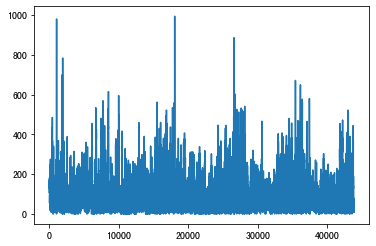

In [7]:
plt.plot(data['pollution'].values)

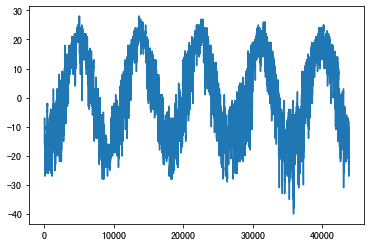

In [8]:
plt.plot(data['dew'].values)

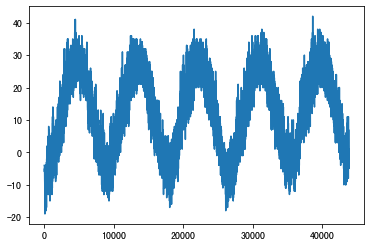

In [9]:
plt.plot(data['temp'].values)

(array([15290.,     0.,     0.,  9384.,     0.,     0., 14130.,     0.,
            0.,  4996.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

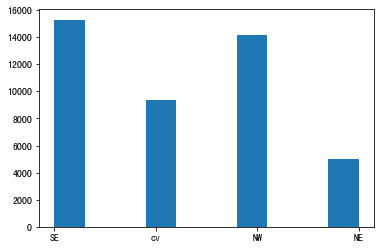

In [10]:
plt.hist(data['wnd_dir'].values)

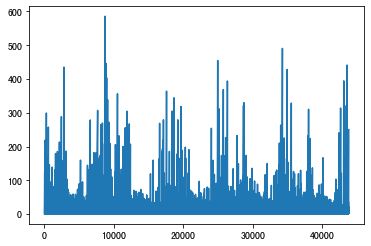

In [11]:
plt.plot(data['wnd_spd'].values)

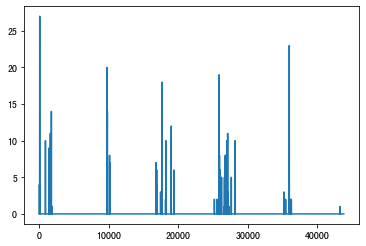

In [12]:
plt.plot(data['snow'].values)

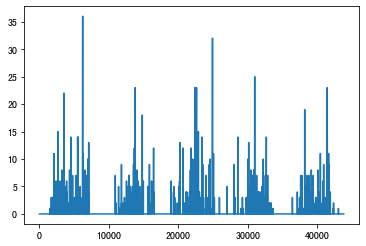

In [13]:
plt.plot(data['rain'].values)

In [14]:
# 将时间序列数据转换为适合监督学习的数据
"""
data：序列，列表或二维的NumPy数组。 必需的参数。
n_in：作为输入步长（X）。 值可能介于[1..len（data）]，可选参数。 默认为1。
n_out：作为输出步长（y）。 值可以在[0..len（data）-1]之间， 可选参数。 默认为1。
dropnan：Boolean是否删除具有NaN值的行。 可选参数。 默认为True。
"""
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []
    # i: n_in, n_in-1, ..., 1
    # 代表t-n_in, ... ,t-1
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # 预测序列(t,t+1...)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [15]:
# 对wnd_dir 这列进行labelencoder标签编码
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
data['wnd_dir'] = LabelEncoder().fit_transform(data['wnd_dir'])
data

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,2,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,2,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,2,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,2,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,1,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,1,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,1,242.70,0,0


In [16]:
# 对数据进行无量纲化，统一数据区间
minmax = MinMaxScaler()
scaled = minmax.fit_transform(data.values)
scaled

array([[0.12977867, 0.35294118, 0.24590164, ..., 0.00229001, 0.        ,
        0.        ],
       [0.14889336, 0.36764706, 0.24590164, ..., 0.00381099, 0.        ,
        0.        ],
       [0.15995976, 0.42647059, 0.2295082 , ..., 0.00533197, 0.        ,
        0.        ],
       ...,
       [0.01006036, 0.26470588, 0.26229508, ..., 0.41399641, 0.        ,
        0.        ],
       [0.00804829, 0.26470588, 0.24590164, ..., 0.42086644, 0.        ,
        0.        ],
       [0.01207243, 0.27941176, 0.26229508, ..., 0.4262155 , 0.        ,
        0.        ]])

In [17]:
reframed = series_to_supervised(scaled, 1, 1)
# 保存到本地
reframed.to_csv('reframed-1.csv')
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545455,0.666667,0.005332,0.000000,0.0
3,0.159960,0.426471,0.229508,0.545455,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563636,0.666667,0.008391,0.037037,0.0
4,0.182093,0.485294,0.229508,0.563636,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563636,0.666667,0.009912,0.074074,0.0
5,0.138833,0.485294,0.229508,0.563636,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563636,0.666667,0.011433,0.111111,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,0.010060,0.264706,0.278689,0.763636,0.333333,0.385730,0.000000,0.0,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0
43796,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0
43797,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0
43798,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0,0.008048,0.264706,0.245902,0.781818,0.333333,0.420866,0.000000,0.0


In [18]:
# 去掉不需要预测的列，即var2(t) var3(t) var4(t) var5(t) var6(t) var7(t) var8(t)
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed
# reframed.to_csv('reframed-2.csv')

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545455,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563636,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563636,0.666667,0.009912,0.074074,0.0,0.109658
...,...,...,...,...,...,...,...,...,...
43795,0.010060,0.264706,0.278689,0.763636,0.333333,0.385730,0.000000,0.0,0.008048
43796,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0,0.010060
43797,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0,0.010060
43798,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0,0.008048


In [19]:
values=reframed.values
values

array([[0.12977867, 0.35294118, 0.24590164, ..., 0.        , 0.        ,
        0.14889336],
       [0.14889336, 0.36764706, 0.24590164, ..., 0.        , 0.        ,
        0.15995976],
       [0.15995976, 0.42647059, 0.2295082 , ..., 0.        , 0.        ,
        0.18209256],
       ...,
       [0.01006036, 0.26470588, 0.26229508, ..., 0.        , 0.        ,
        0.01006036],
       [0.01006036, 0.26470588, 0.26229508, ..., 0.        , 0.        ,
        0.00804829],
       [0.00804829, 0.26470588, 0.24590164, ..., 0.        , 0.        ,
        0.01207243]])

In [20]:
# 数据集划分 8/2，时序数据不能用train_test_split
n = int(len(values)*0.8)
train = values[:n,:]
test = values[n:,:]

train_x ,train_y =  train[:,:-1],train[:,-1]
test_x , test_y = test[:,:-1],test[:,-1]

In [21]:
# 将数据转换为3D格式:[样本数，时间步长，特征数]
train_x = train_x.reshape((train_x.shape[0],1,train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0],1,test_x.shape[1]))

In [22]:
train_x.shape,test_x.shape

((35039, 1, 8), (8760, 1, 8))

## 3.使用LSTM进行建模预测

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM , Dense

# 建模
model = Sequential()
model.add(LSTM(50 , input_shape=(train_x.shape[1],train_x.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam' ,loss='mse')
# 查看模型结构
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11800     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________


In [24]:
# 模型训练
result = model.fit(train_x ,train_y ,epochs=10 ,batch_size=64 ,validation_data=(test_x,test_y) ,verbose=2 ,shuffle=False)

Epoch 1/10
548/548 - 6s - loss: 0.0031 - val_loss: 0.0076
Epoch 2/10
548/548 - 5s - loss: 8.6488e-04 - val_loss: 0.0028
Epoch 3/10
548/548 - 6s - loss: 8.0981e-04 - val_loss: 0.0018
Epoch 4/10
548/548 - 5s - loss: 8.0214e-04 - val_loss: 0.0015
Epoch 5/10
548/548 - 5s - loss: 8.0061e-04 - val_loss: 0.0013
Epoch 6/10
548/548 - 5s - loss: 8.0108e-04 - val_loss: 0.0012
Epoch 7/10
548/548 - 5s - loss: 8.0174e-04 - val_loss: 0.0011
Epoch 8/10
548/548 - 5s - loss: 8.0177e-04 - val_loss: 0.0011
Epoch 9/10
548/548 - 6s - loss: 8.0140e-04 - val_loss: 0.0011
Epoch 10/10
548/548 - 5s - loss: 8.0087e-04 - val_loss: 0.0011


In [25]:
# 模型预测
train_pre = model.predict(train_x)
test_pre = model.predict(test_x)
train_pre.shape, test_pre.shape

((35039, 1), (8760, 1))

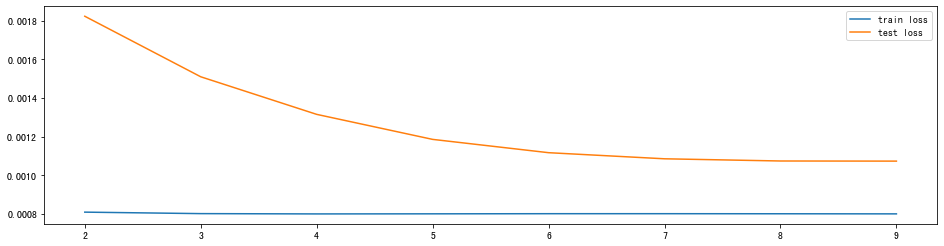

In [26]:
# loss可视化
train_loss = result.history['loss']
val_loss = result.history['val_loss']
plt.figure(figsize=(16, 4))
x = list(range(len(train_loss)))
plt.plot(x[2:], train_loss[2:], label='train loss')
plt.plot(x[2:], val_loss[2:], label='test loss')
plt.legend(loc='best')
plt.show()

In [27]:
# 呈现原始数据，训练结果，预测结果
def plot_img(source_data_set, train_pre, test_pre):

    # 原始数据(蓝色)
    plt.plot(source_data_set[:,-1], label='real',c='b')
    # 训练数据（黄色）
    plt.plot([x for x in train_pre], label='train_predict',c='y')
    # 测试数据(红色)
    plt.plot([None for _ in train_pre]+[x for x in test_pre], label='test_predict' ,c='r')
    plt.legend(loc='best')

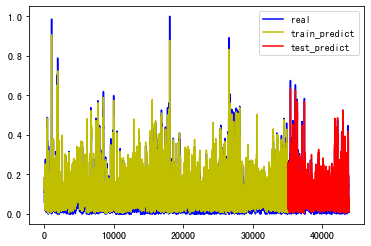

In [28]:
plot_img(values, train_pre ,test_pre)